# Basic Flopy

In this notebook, we will blast through basic flopy usage.  There is a lot to cover in flopy, so this will just hit the highlights

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy
import pyemu

Let's jump right in and load an existing model (one we will use for the rest of the week). We will use the `model_ws` (model workspace) to access these files in a different directory:

In [3]:
model_ws = os.path.join("..","base_model_files")
os.listdir(model_ws)


['add_north_ghbs.py',
 'forecast_truth.csv',
 'freyberg.bas',
 'freyberg.cbc',
 'freyberg.chk',
 'freyberg.dis',
 'freyberg.drn',
 'freyberg.ghb',
 'freyberg.hds',
 'freyberg.list',
 'freyberg.lmt6',
 'freyberg.locations',
 'freyberg.mpbas',
 'freyberg.mpenpt',
 'freyberg.mplist',
 'freyberg.mpnam',
 'freyberg.mppthln',
 'freyberg.mpsim',
 'freyberg.nam',
 'freyberg.nwt',
 'freyberg.oc',
 'freyberg.rch',
 'freyberg.sfr',
 'freyberg.sfr.out',
 'freyberg.upw',
 'freyberg.wel',
 'freyberg_mt.adv',
 'freyberg_mt.btn',
 'freyberg_mt.gcg',
 'freyberg_mt.list',
 'freyberg_mt.nam',
 'freyberg_mt.rct',
 'freyberg_mt.sft',
 'freyberg_mt.sftcobs.out',
 'freyberg_mt.ssm',
 'heads.hds',
 'kriged_bottom_elevs.ref',
 'kriged_bottom_Freyberg1.0.ref',
 'make_ss_obs.pt',
 'make_ss_obs.py',
 'mfnwt.exe',
 'mp_ibound_1.ref',
 'mp_ibound_2.ref',
 'mp_ibound_3.ref',
 'MT3D.CNF',
 'MT3D001.MAS',
 'MT3D001.UCN',
 'mt3d_link.ftl',
 'obs_data.csv',
 'obs_loc.csv',
 'pestpp-glm',
 'pestpp-ies',
 'pestpp-opt',
 '

Do these file types look familiar???

In [4]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws,verbose=True)


Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> ..\base_model_files\freyberg.nam

--------------------------------------------------
External unit dictionary:
{2: filename:..\base_model_files\freyberg.list, filetype:LIST, 11: filename:..\base_model_files\freyberg.dis, filetype:DIS, 13: filename:..\base_model_files\freyberg.bas, filetype:BAS6, 31: filename:..\base_model_files\freyberg.upw, filetype:UPW, 19: filename:..\base_model_files\freyberg.rch, filetype:RCH, 32: filename:..\base_model_files\freyberg.nwt, filetype:NWT, 14: filename:..\base_model_files\freyberg.oc, filetype:OC, 30: filename:..\base_model_files\freyberg.lmt6, filetype:LMT6, 20: filename:..\base_model_files\freyberg.wel, filetype:WEL, 17: filename:..\base_model_files\freyberg.sfr, filetype:SFR, 23: filename:..\base_model_files\freyberg.ghb, filetype:GHB, 50: filename:..\base_model_files\freyberg.cbc, filetype:DATA(BINARY), 51: filename:..\base_model_f

In [5]:
m

MODFLOW 3 layer(s) 40 row(s) 20 column(s) 2 stress period(s)

individual packages are accessible through their 3-letter extension (except for the basic package, which is `bas6` for some reason :facepalm: )

In [6]:
m.dis

C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When maki


    MODFLOW Discretization Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.Modflow`) to which
        this package will be added.
    nlay : int
        Number of model layers (the default is 1).
    nrow : int
        Number of model rows (the default is 2).
    ncol : int
        Number of model columns (the default is 2).
    nper : int
        Number of model stress periods (the default is 1).
    delr : float or array of floats (ncol), optional
        An array of spacings along a row (the default is 1.0).
    delc : float or array of floats (nrow), optional
        An array of spacings along a column (the default is 0.0).
    laycbd : int or array of ints (nlay), optional
        An array of flags indicating whether or not a layer has a Quasi-3D
        confining bed below it. 0 indicates no confining bed, and not zero
        indicates a confining bed. LAYCBD for the bottom layer must be 0. (the
    

In each package, the array-type data are housed in special array-handling classes:

In [7]:
m.dis.top

In [8]:
m.rch.rech

In [9]:
m.bas6.strt

List-type data also have special handlers - the list type data is always stored in the `stress_period_data` attribute:

In [10]:
m.ghb.stress_period_data

Each of these has an `array` attribute to access the actual data values

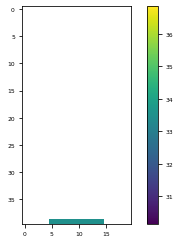

In [11]:
arr = m.ghb.stress_period_data.array["bhead"]
cb = plt.imshow(arr[0,0,:,:])
plt.colorbar(cb)

In [12]:
m.rch.rech.array.shape

(2, 1, 40, 20)


And of course, `SFR` has to be difficult

In [13]:
pd.DataFrame.from_records(m.sfr.reach_data).head()

,node,k,i,j,iseg,ireach,rchlen,strtop,slope,strthick,strhc1,thts,thti,eps,uhc,reachID,outreach
0,15,0,0,15,1,1,250.0,34.000000,0.00005,1.0,0.1,0.0,0.0,0.0,0.0,1,2
1,35,0,1,15,2,1,250.0,33.987179,0.00005,1.0,0.1,0.0,0.0,0.0,0.0,2,3
2,55,0,2,15,3,1,250.0,33.974358,0.00005,1.0,0.1,0.0,0.0,0.0,0.0,3,4
3,75,0,3,15,4,1,250.0,33.961540,0.00005,1.0,0.1,0.0,0.0,0.0,0.0,4,5
4,95,0,4,15,5,1,250.0,33.948719,0.00005,1.0,0.1,0.0,0.0,0.0,0.0,5,6


In [14]:
pd.DataFrame.from_records(m.sfr.segment_data[0]).head()

,nseg,icalc,outseg,iupseg,iprior,nstrpts,flow,runoff,etsw,pptsw,...,uhc1,hcond2,thickm2,elevdn,width2,depth2,thts2,thti2,eps2,uhc2
0,1,1,2,0,0,0,10000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
1,2,1,3,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,3,1,4,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
3,4,1,5,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
4,5,1,6,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


## Exporting to shapefiles

You can export the entire model, individual packages or individual attributes:

In [15]:
m.export("model.shp")
m.dis.export("dis.shp")
m.dis.top.export("top.shp")
m.ghb.stress_period_data.export("ghb.shp")

wrote model.shp
wrote dis.shp
wrote top.shp
wrote ghb.shp


How does flopy know where the model is in space? The spatial reference:

In [16]:
m.modelgrid

xll:0.0; yll:0.0; rotation:0.0; proj4_str:+init=EPSG:4326; units:meters; lenuni:2

# changing `model_ws` and writing

It is probably good form to not overwrite the existing files.  To avoid this danger, we can change the model workspace and then write a new set of model files in this location:

In [17]:
m.change_model_ws("flopy_temp",reset_external=True)
m.write_input()


changing model workspace...
   flopy_temp

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  UPW
   Package:  RCH
   Package:  NWT
   Package:  OC
   Package:  LMT6
   Package:  WEL
   Package:  SFR
   Package:  GHB
 


In [18]:
os.listdir(m.model_ws)

['freyberg.bas',
 'freyberg.cbc',
 'freyberg.dis',
 'freyberg.ghb',
 'freyberg.hds',
 'freyberg.list',
 'freyberg.lmt6',
 'freyberg.nam',
 'freyberg.nwt',
 'freyberg.oc',
 'freyberg.rch',
 'freyberg.sfr',
 'freyberg.sfr.out',
 'freyberg.upw',
 'freyberg.wel',
 'mfnwt.exe',
 'mt3d_link.ftl']

# Run the model

A little trickery is needed here: we need to get the right MODFLOW binary into this new `model_ws`.  What should we do? 

### DIY: use `shutil` and `os` to copy the `mfnwt` binary into the new `model_ws` (this is a super-common task)

In [21]:
print(os.listdir("bin")) #hint the platform specific binaries in the bin dir
# your code here: os.path.join, shutil.copy2
src_exe = os.path.join("bin","win","mfnwt.exe")
dest_exe = os.path.join("flopy_temp","mfnwt.exe")
shutil.copy2(src_exe,dest_exe)

['.DS_Store', 'linux', 'mac', 'win']


'flopy_temp\\mfnwt.exe'

I prefer to use the pyemu run function here because it is more tolerant of cross platform issues...

In [22]:
pyemu.os_utils.run("mfnwt freyberg.nam",cwd=m.model_ws)

If you go back to the terminal, you should see the output from MODFLOW-NWT...

# Post-processing

Flopy has lots of support to help use deal with the terrible MDOFLOW file formats

In [23]:
mflist = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))

In [24]:
inc_df,cum_df = mflist.get_dataframes(start_datetime="5-11-1955",diff=True)
inc_df

,constant_head,head_dep_bounds,in-out,percent_discrepancy,recharge,storage,stream_leakage,total,wells
1965-05-08,0.0,-50.153320,0.046387,0.00,2588.760010,0.0000,-288.560089,0.046387,-2250.0
1966-05-08,0.0,-67.346497,-0.365200,-0.01,2284.199951,-25.3134,-391.905182,-0.365234,-1800.0


Where did those dates come from???  You can pass a `start_datetime` string to the `get_dataframes()` method to control those better.  In fact, the flopy model instance has its own `start_datetime` attribute for temporally locating the model inputs...

### DIY: plot the NET increment water budget as a bar chart but change the starting datetime to 5 Nov 1955:

<AxesSubplot:>

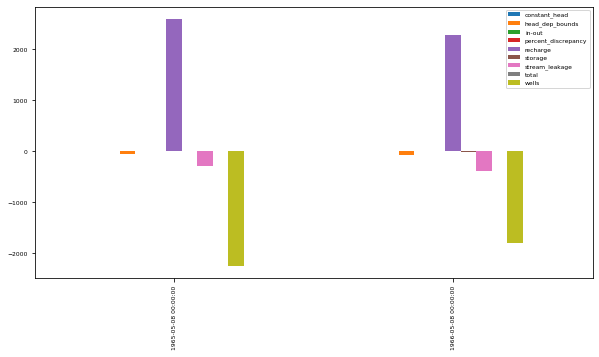

In [27]:
# hint: checkout the options you can pass get_dataframes()
# your code here
inc_df.plot(kind="bar",figsize=(10,5))

We can also load the binary head save file

In [29]:
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"))
hds

In [30]:
hds.get_times()

[3650.0, 4015.0]

In [31]:
data = hds.get_data() #by defauly, get_data() returns the last entry
data.shape

(3, 40, 20)

[<AxesSubplot:title={'center':'data Layer 1'}>,
 <AxesSubplot:title={'center':'data Layer 2'}>,
 <AxesSubplot:title={'center':'data Layer 3'}>]

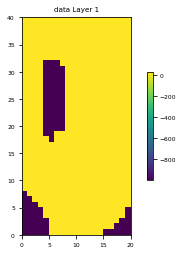

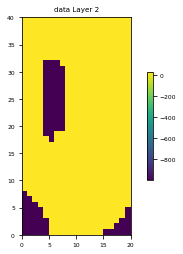

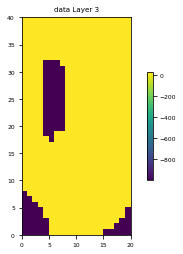

In [32]:
hds.plot(mflay=None,totim=None,colorbar=True) # if these args are None, then you get all layers from the last entry

That looks kinda shitty...but we can do better! if you pass the model instance the the `HeadFile` constructor, the plot routines will use the ibound to mask...

### DIY: re-instantiate the `HeadFile` object but pass it the model instance and plot layer 1 heads from both stress periods:

[<AxesSubplot:title={'center':'data Layer 1'}>,
 <AxesSubplot:title={'center':'data Layer 2'}>,
 <AxesSubplot:title={'center':'data Layer 3'}>]

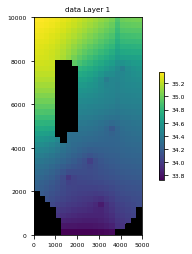

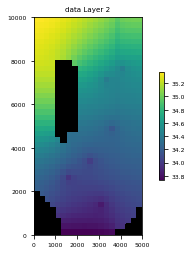

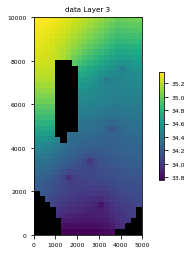

In [33]:
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
hds.plot(mflay=None,totim=None,colorbar=True)

The `HeadFile` class also support writing to shapefiles:

In [34]:
hds.to_shapefile("hds.shp")

wrote hds.shp


The same type of support is available for the cell-by-cell budget file:

In [35]:
cbc = flopy.utils.CellBudgetFile(os.path.join(m.model_ws,m.name+".cbc"))
cbc.list_records()

(1, 1, b'   CONSTANT HEAD', 20, 40, -3, 2, 3650., 3650., 3650., b'', b'', b'', b'')
(1, 1, b'FLOW RIGHT FACE ', 20, 40, -3, 1, 3650., 3650., 3650., b'', b'', b'', b'')
(1, 1, b'FLOW FRONT FACE ', 20, 40, -3, 1, 3650., 3650., 3650., b'', b'', b'', b'')
(1, 1, b'FLOW LOWER FACE ', 20, 40, -3, 1, 3650., 3650., 3650., b'', b'', b'', b'')
(1, 1, b'           WELLS', 20, 40, -3, 5, 3650., 3650., 3650., b'', b'', b'', b'')
(1, 1, b'        RECHARGE', 20, 40, -3, 3, 3650., 3650., 3650., b'', b'', b'', b'')
(1, 1, b'  STREAM LEAKAGE', 20, 40, -3, 5, 3650., 3650., 3650., b'', b'', b'', b'')
(1, 2, b'         STORAGE', 20, 40, -3, 1, 365., 365., 4015., b'', b'', b'', b'')
(1, 2, b'   CONSTANT HEAD', 20, 40, -3, 2, 365., 365., 4015., b'', b'', b'', b'')
(1, 2, b'FLOW RIGHT FACE ', 20, 40, -3, 1, 365., 365., 4015., b'', b'', b'', b'')
(1, 2, b'FLOW FRONT FACE ', 20, 40, -3, 1, 365., 365., 4015., b'', b'', b'', b'')
(1, 2, b'FLOW LOWER FACE ', 20, 40, -3, 1, 365., 365., 4015., b'', b'', b'', b'')
(1

Lets plot up some cell-by-cell info:

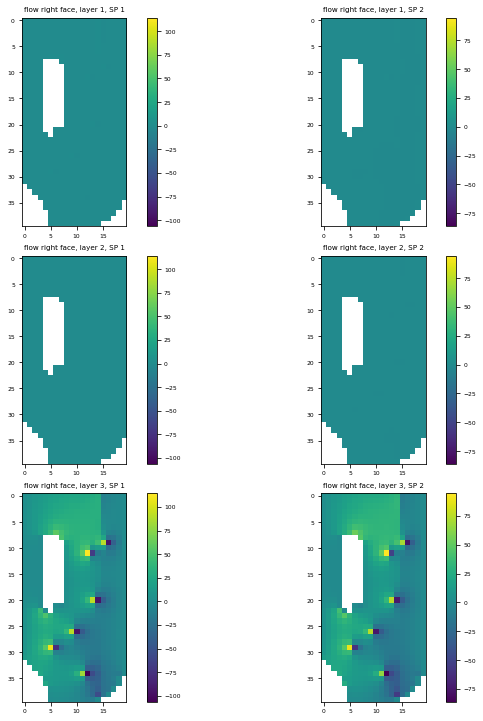

In [36]:
text = "flow right face"
times = cbc.get_times()
fig,axes = plt.subplots(m.nlay,m.nper,figsize=(10,10))
for kper in range(m.nper):
    data = cbc.get_data(text=text,totim=times[kper],full3D=True)[0]
    data = np.ma.masked_where(m.bas6.ibound.array<1,data)
    vmin,vmax = data.min(),data.max()
    
    for k in range(m.nlay):    
        cb = axes[k,kper].imshow(data[k,:,:],vmin=vmin,vmax=vmax)
        axes[k,kper].set_title("{0}, layer {1}, SP {2}".format(text,k+1,kper+1))
        plt.colorbar(cb,ax=axes[k,kper])
plt.tight_layout()
plt.show()


### DIY: change the `model_ws` again (and get the binary into the new `model_ws`).  Then change everyone's fav hydrogeoloical obsession `hk` in each layer by a factor of 10, run the model and *visually* compare the water budget and heads to the base case we ran through above.


creating model workspace...
   flopy_temp1

changing model workspace...
   flopy_temp1

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  UPW
   Package:  RCH
   Package:  NWT
   Package:  OC
   Package:  LMT6
   Package:  WEL
   Package:  SFR
   Package:  GHB
 


[<AxesSubplot:title={'center':'data Layer 1'}>,
 <AxesSubplot:title={'center':'data Layer 2'}>,
 <AxesSubplot:title={'center':'data Layer 3'}>]

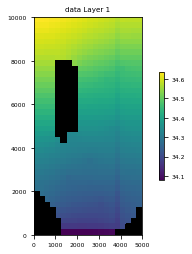

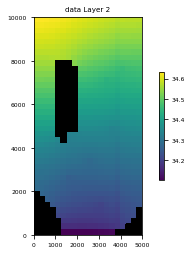

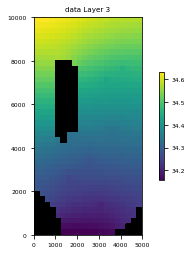

In [38]:
#step 0: change_model_ws
m.change_model_ws("flopy_temp1",reset_external=True)
#step 1: change hk: m.upw.hk
m.upw.hk *= 10.0
#step 2: write inputs
m.write_input()
#step 3: copy binary into model_ws
src_exe = os.path.join("bin","win","mfnwt.exe")
dest_exe = os.path.join("flopy_temp1","mfnwt.exe")
shutil.copy2(src_exe,dest_exe)
#step 4: run model
pyemu.os_utils.run("mfnwt freyberg.nam",cwd=m.model_ws)
#step 5: plot results
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
hds.plot(mflay=None,totim=None,colorbar=True)

# Creating a new model and adding packages

Now we will go through the super painful process of creating a model from scratch

In [ ]:
m = flopy.modflow.Modflow("newmodel",model_ws="newmodel",
                          version="mfnwt",exe_name="mfnwt",
                          external_path="data")

In [ ]:
ncol,nper = 10000,365
tot_length = 100
delr = tot_length / ncol
steady,perlen = [True],[1.0]
for kper in range(nper-1):
    steady.append(False)
    perlen.append(10.0)


In [ ]:
dis = flopy.modflow.ModflowDis(m,nrow=1,ncol=ncol,nlay=1,
                               nper=nper,delr=delr,top=10,
                               botm=0,steady=steady,perlen=perlen)

In [ ]:
m.dis.delr.array[0]

In [ ]:
ibound = np.ones((m.nlay,m.nrow,m.ncol))
ibound[:,:,[0,-1]] = -1 #set constant heads in the first and last column
strt = np.ones_like(ibound)
strt[:,:,-1] = 10 # set the initial heads in the last (constant head) column
bas = flopy.modflow.ModflowBas(m,strt=strt,ibound=ibound)

In [ ]:
upw = flopy.modflow.ModflowUpw(m,hk=10,ss=0.001,sy=0.1)

In [ ]:
nwt = flopy.modflow.ModflowNwt(m)

In [ ]:
oc = flopy.modflow.ModflowOc(m)

To add a boundary condition, we need to generate a dict of stress period key and list-type data values for the wel package, the list type data need to have k, i, j, and flux.  Each BC package has a `get_default_dtype()` method to show you what it is expecting:

In [ ]:
flopy.modflow.ModflowWel.get_default_dtype()

So let's set a well in (about) the center of the model with some pumping in each stress period:

In [ ]:
spd = {}
np.random.seed(111)
for kper in range(m.nper):
    spd[kper] = [0,0,int(m.ncol/2),np.random.uniform(-10,-50,1)]
spd

In [ ]:
wel = flopy.modflow.ModflowWel(m,stress_period_data=spd)

In [ ]:
m.write_input()

In [ ]:
shutil.copy2(os.path.join("bin","mac","mfnwt"),os.path.join(m.model_ws,"mfnwt"))

In [ ]:
pyemu.os_utils.run("mfnwt newmodel.nam",cwd=m.model_ws)

In [ ]:
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"))
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect=1000)
hds.plot(axes=[ax],colorbar=True)


In [ ]:
mflist = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
inc,cum = mflist.get_dataframes(diff=True)
inc.plot(figsize=(10,10))

Just to show you how power this can be, lets go back up and change the number of columns and stress period...

# DIY: create a 3 layer, 11 row, 11 col model with 365 daily stress periods (first stress period steady-state).  Put constant heads in layer 1 on the left and right with a gradient across the model and a single pumping well in the center of layer 3 and drive the pumping well with random values for each day. Run this model and post-process as above. Copy-and-paste is not cheating!